In [356]:
##### Loading all the necessary libraries


import pandas as pd
import numpy as np
import re
import spacy

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt 

%matplotlib inline


from datetime import datetime

import json



from elasticsearch import helpers
from elasticsearch import Elasticsearch

In [357]:
#### Initializing spacy for text processing
nlp = spacy.load('en_core_web_sm')

#### Initializing Elastic Search
es=Elasticsearch()

In [358]:
#### Loading dataset from csv file using pandas

df=pd.read_csv("metadata.csv")

C:\Users\Myra\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [359]:
#### Data overview
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [360]:
#### Checking for missing values in complete dataset
df.isnull().sum()

cord_uid                 0
sha                 299973
source_x                 0
title                  223
doi                 199517
pmcid               290607
pubmed_id           231259
license                  0
abstract            124997
publish_time           218
authors              13110
journal              30185
mag_id              450385
who_covidence_id    268359
arxiv_id            444490
pdf_json_files      299973
pmc_json_files      329971
url                 180409
s2_id                41014
dtype: int64

In [361]:
#### Dropping columns with more than 85% missing values
percent_missing = df.isnull().sum() * 100 / len(df)
dropout_columns=percent_missing[percent_missing>85].index.to_list()
print("Columns to be dropped")
print(dropout_columns)
df.drop(dropout_columns,axis=1,inplace=True)

Columns to be dropped
['mag_id', 'arxiv_id']


In [362]:
##### Checking for missing values in title, abstract and authors field
df[pd.isna(df.title) | pd.isna(df.abstract) | pd.isna(df.authors)].shape

(128062, 17)

In [363]:
##### Filtering out missing values in title,abstract and authors fields from dataset

df=df[pd.notna(df.title) & pd.notna(df.abstract) & pd.notna(df.authors)]

In [364]:
##### Converting type of publish time from object to datetime
df.publish_time=pd.to_datetime(df.publish_time)

In [365]:
##### Checking for missing values in publish_time field
df[pd.isna(df.publish_time)].shape

(188, 17)

In [366]:
##### Filtering out missing values in publish_time field in dataset

df=df[pd.notna(df.publish_time)]

In [367]:
##### Due to filtering out indices are disturbed, so resetting index
df.reset_index(drop=True,inplace=True)

In [368]:
df.shape

(322135, 17)

In [369]:
##### Selecting only 1000 documents from the dataset
df=df.iloc[:1000,:]

In [337]:
##### Splitting multiple authors string field into array like object.
df.authors=df.authors.apply(lambda x: [y.strip() for y in x.split(";")])

In [370]:
#### Combining the title and abstract field to a single field for natural language processing
docs_text=df.title+" "+df.abstract

In [371]:
#### Converting the pandas series object to list
docs_text=docs_text.to_list()

In [372]:
#### Tokenization, Normalization, Cleaning and Lemmatization
clean_doc_text=[]
for i,text in enumerate(docs_text):
    ### remove extra spaces, tabs and newlines    
    
    text=' '.join(text.split())
    ### remove punctuations
    text = re.sub(r'[^\w\s]',' ',text)
    
    ### remove numbers and digits
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)


    ### remove multiple spaces
    text = re.sub(' +', ' ', text)

    
    #### remove stop words
    spacy_text=nlp(text)
    tokens=[t.text for t in spacy_text]
    tokens=[t for t in tokens if not nlp.vocab[t].is_stop]
    
    text=' '.join(tokens)
    
    ##### lemmatization and lower casing of text
    spacy_text=nlp(text)
    tokens=[t.lemma_ for t in spacy_text]
    tokens=[t.lower() for t in tokens]
    text=' '.join(tokens)
    

    clean_doc_text.append(text)

In [373]:
#### Computing TFIDF matrix and extracting keywords from documents

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(clean_doc_text)
keywords=[]
for vector in vectors:
    names = vectorizer.get_feature_names()
    data = vector.T.todense().tolist()
    tmp = pd.DataFrame(data, index=names,columns=["tfidf"])
    tmp=tmp.sort_values(by=["tfidf"],ascending=False)
    words=tmp.index[:10].tolist()
    keywords.append(words)

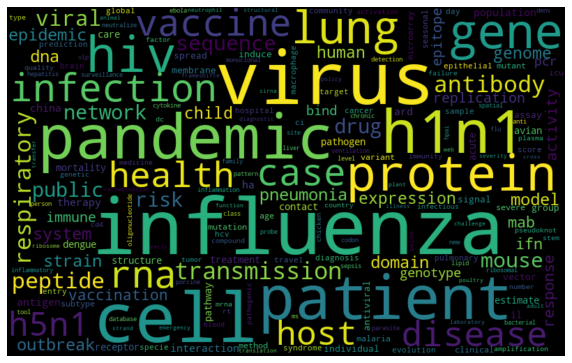

In [374]:
#### Visualization of keywords in dataset

flat_keywords = [item for sublist in keywords for item in sublist]

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(flat_keywords))
        
        

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [379]:
#### Adding keywords to our dataset
df["keywords"]=keywords

In [378]:
#### Adding index field in datset for elastic search
df["_index"]="covid"

In [377]:
#### Adding id field in datset for elastic search

df["_id"]=df.cord_uid

In [380]:
#### Converting publish time to string with format
df.publish_time=df.publish_time.apply(lambda x: x.strftime("%Y-%m-%d"))

In [349]:
#### Converting dataset to json form 
json_obj=df.to_json(orient="records")
json_obj=json.loads(json_obj)

In [384]:
##### Creating index at elasticsearch and specifying mapping for custom fields in dataset
es.indices.create(index="covid",ignore=400, body={
    "mappings": {
        "properties": {
          "authors":{
            "type": "keyword",
          },
          "keywords":{
            "type": "keyword",
          },
          "publish_time":{
              "type" : "date",
              "format" : "yyyy-MM-dd"
          }
        }
  }
})

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'covid'}

In [385]:
#### Uploading data to elastic search using helpers
helpers.bulk(es, json_obj)

(1000, [])

In [387]:
#### Search query for authors 
es.search(index="covid", body={"query": {"match": {
      "authors": 'Crouch, Erika C'
    }}})

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 9.928994,
  'hits': [{'_index': 'covid',
    '_type': '_doc',
    '_id': 'ejv2xln0',
    '_score': 9.928994,
    '_source': {'cord_uid': 'ejv2xln0',
     'sha': '06ced00a5fc04215949aa72528f2eeaae1d58927',
     'source_x': 'PMC',
     'title': 'Surfactant protein-D and pulmonary host defense',
     'doi': '10.1186/rr19',
     'pmcid': 'PMC59549',
     'pubmed_id': '11667972',
     'license': 'no-cc',
     'abstract': 'Surfactant protein-D (SP-D) participates in the innate response to inhaled microorganisms and organic antigens, and contributes to immune and inflammatory regulation within the lung. SP-D is synthesized and secreted by alveolar and bronchiolar epithelial cells, but is also expressed by epithelial cells lining various exocrine ducts and the mucosa of the gastrointestinal and genitourinary tracts. SP-D, a col

In [386]:
# from elasticsearch import Elasticsearch

# es=Elasticsearch()
# es.indices.delete(index='covid', ignore=[400, 404])